## 0. モジュールの確認

In [1]:
!pip list

Package                Version            
---------------------- -------------------
absl-py                0.9.0              
alembic                1.4.1              
astor                  0.8.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.2              
bleach                 3.1.3              
blinker                1.4                
bokeh                  1.4.0              
cachetools             4.1.0              
certifi                2019.11.28         
certipy                0.1.3              
cffi                   1.14.0             
chardet                3.0.4              
click                  7.1.1              
cloudpickle            1.3.0              
conda                  4.8.2              
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython     

## 1. モジュールのインポート

In [1]:
import os,re
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models
from keras.models import Model
from keras import Input
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## 2. 学習データの可視化

### 1. MINSTをロード

In [2]:
# 学習データとテストデータを取得する。
(_x_train_val, _y_train_val), (_x_test, _y_test) = mnist.load_data()
# 学習中の検証データがないので、train_test_split()を使って学習データ8割、検証データを2割に分割する。test_sizeが検証データの割合になっている。
_x_train, _x_val, _y_train, _y_val = train_test_split(_x_train_val, _y_train_val, test_size=0.2)

print("x_train   : ", _x_train.shape) # x_train   :  (48000, 28, 28)
print("y_train   : ", _y_train.shape) # y_train   :  (48000,)
print("x_val      : ", _x_val.shape) # x_val      :  (12000, 28, 28)
print("y_val      : ", _y_val.shape) # y_val      :  (12000,)
print("x_test    : ", _x_test.shape) # x_test    :  (10000, 28, 28)
print("y_test    : ", _y_test.shape) # y_test    :  (10000,)

x_train   :  (48000, 28, 28)
y_train   :  (48000,)
x_val      :  (12000, 28, 28)
y_val      :  (12000,)
x_test    :  (10000, 28, 28)
y_test    :  (10000,)


### 2. 学習データを表示

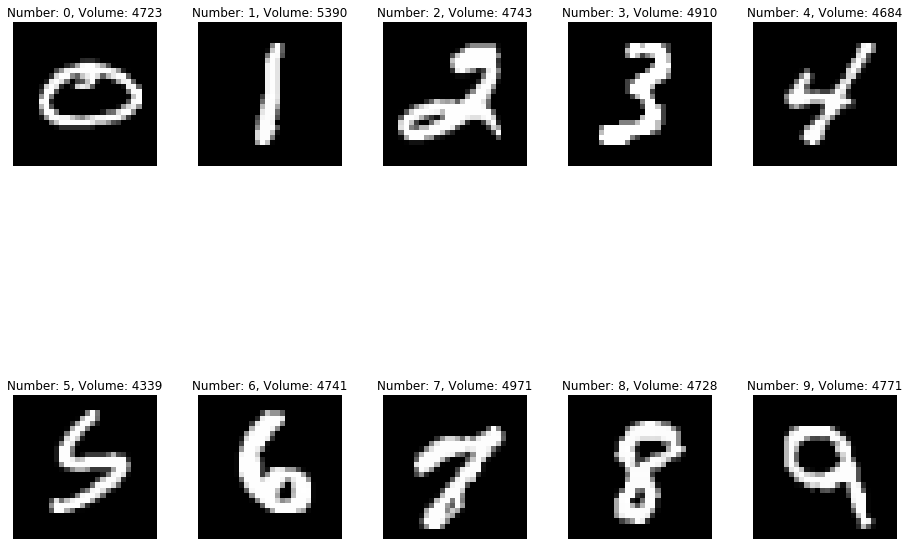

In [3]:
plt.figure(figsize=(13,13))

# MNISTの0から9の画像をそれぞれ表示する。
for i in range(10):
    data = [(x,t) for x, t in zip(_x_train, _y_train) if t == i]
    x, y = data[0]
    
    # 第1引数(縦に表示する量):5, 第2引数(横に表示する量): 2, 第3引数(位置の指定)
    plt.subplot(2, 5, i+1)
    # タイトルを表示する。対応する数と画像枚数を表示している。
    plt.title("Number: {0}, Volume: {1}".format(y, len(data)))
    # 画像を見やすいように座標軸を非表示にする。
    plt.axis("off")
    # 画像を表示
    plt.imshow(x, cmap='gray')

plt.tight_layout()
plt.show()

## データの前処理

### 前処理用の関数を定義

In [4]:
# 訓練、検証、テストデータの前処理用関数。
def preprocess(data, label=False):
    if label:
        # 教師データはto_categorical()でone-hot-encodingする。
        data = to_categorical(data)
    else:
        # 入力画像は、astype('float32')で型変換を行い、レンジを0-1にするために255で割る。
        # 0-255 -> 0-1
        data = data.astype('float32') / 255
        # Kerasの入力データの形式は(ミニバッチサイズ、横幅、縦幅、チャネル数)である必要があるので、reshape()を使って形式を変換する。
        # (sample, width, height) -> (sample, width, height, channel)
        data = data.reshape((-1, 28, 28, 1))

    return data

### 訓練、検証、テストのデータに前処理関数を実行

In [5]:
x_train = preprocess(_x_train)
x_val= preprocess(_x_val)
x_test = preprocess(_x_test)

y_train = preprocess(_y_train, label=True)
y_val = preprocess(_y_val, label=True)
y_test = preprocess(_y_test, label=True)

In [33]:
# 48000枚の横軸×縦軸の0~1の間の画素が存在してる
print(x_train.shape) # (48000, 28, 28, 1)
print(x_train[0][13][22][0], x_train[0][13][22][0] * 255) # 0.5529412 141.0000067949295
print(x_val.shape) # (12000, 28, 28, 1)
print(x_test.shape) # (10000, 28, 28, 1)
print(x_train.max()) # 1.0
print(x_val.max()) # 1.0
print(y_test.max()) # 1.0
print(y_train.shape) # (48000, 10)
print(y_val.shape) # (12000, 10) 
print(y_test.shape) # (10000, 10)

(48000, 28, 28, 1)
0.5529412 141.0000067949295
(12000, 28, 28, 1)
(10000, 28, 28, 1)
1.0
1.0
1.0
(48000, 10)
(12000, 10)
(10000, 10)


## モデル定義

### Sequentialモデル

In [34]:
def model_sequential():
    activation = 'relu'

    model = models.Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', name='conv1', input_shape=(28, 28 , 1)))
    model.add(Activation(activation, name='act1'))
    model.add(MaxPooling2D((2, 2), name='pool1'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv2'))
    model.add(Activation(activation, name='act2'))
    model.add(MaxPooling2D((2, 2), name='pool2'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
    model.add(Activation(activation, name='act3'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(64, name='dense4'))
    model.add(Activation(activation, name='act4'))
    model.add(Dense(10, name='dense5'))
    model.add(Activation('softmax', name='last_act'))

    return model